In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from gtda.pipeline import Pipeline
from gtda.time_series import Resampler
from gtda.diagrams import PersistenceEntropy, Scaler, HeatKernel
import numpy as np
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters, TakensEmbedding
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer

We start by analyzing the public data set and looking at the normal operations time series, to set a benchmark for the analysis of well events (abnormal operations). 

In [2]:
def find_shortest_file(path, label):
    tmp = []
    os.chdir(path)
    for file in os.listdir():
        data_df = pd.read_csv(file)
        tmp.append(len(data_df[label]))
    return min(tmp)

In [3]:
def read_files(path, label, limit):
    data = []
    os.chdir(path)
    for file in os.listdir():
        data_df = pd.read_csv(file)
        # fill NaN with an interpolated value
        data_df = data_df.interpolate()
        period = int(len(data_df)/limit)
        periodicSampler = Resampler(period=period)
        # print(file, len(data_df), limit, 'resampled to period:', period)
        # resample the files to that all of them are the same length (in entries)
        # NOTE: timestamps are omitted and timesteps are going to be different for each resampled time series!
        index_sampled, signal_sampled = periodicSampler.fit_transform_resample(data_df.index, data_df[label])
        data.append(signal_sampled)
    data_T = list(map(list, zip(*data)))
    df = pd.DataFrame.from_records(data_T)
    return data, df

In [34]:
find_shortest_file("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/0", "P-TPT")

7010

In [35]:
normal_signals, normal_df = read_files("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/0/", "P-TPT",7000)

In [36]:
normal_df

0           1          2           3          4           5    \
0     8698015.0  13987430.0  8648771.0  13036680.0  8055306.0  14184150.0   
1     8698015.0  13987410.0  8648666.0  13036670.0  8054974.0  14184150.0   
2     8698015.0  13987390.0  8648560.0  13036660.0  8054641.0  14184150.0   
3     8698015.0  13987370.0  8648456.0  13036650.0  8054308.0  14184150.0   
4     8698015.0  13987350.0  8648351.0  13036650.0  8053976.0  14184150.0   
...         ...         ...        ...         ...        ...         ...   
7005  8420715.0  13986730.0  8578317.0  12998830.0  8717964.0  14224980.0   
7006  8420383.0  13986600.0  8578317.0  12999160.0  8717964.0  14224840.0   
7007  8420050.0  13986480.0  8578317.0  12999490.0  8717964.0  14224710.0   
7008  8419717.0  13986350.0  8578317.0  12999830.0  8717964.0  14224580.0   
7009  8419386.0  13986220.0  8578317.0  13000160.0  8717964.0  14224440.0   

             6           7           8           9    ...        587  \
0     14221150.0  20932460.0  13385940.0  21146550.0  ...  8706865.0   
1     14221370.0  20931700.0  13386030.0  21146550.0  ...  8706792.0   
2     14221590.0  20930930.0  13386130.0  21146550.0  ...  8706720.0   
3     14221820.0  20930170.0  13386220.0  21146550.0  ...  8706647.0   
4     14222040.0  20929400.0  13386310.0  21146550.0  ...  8706575.0   
...          ...         ...         ...         ...  ...        ...   
7005  14184150.0  20911490.0  13385700.0  21146550.0  ...  8478569.0   
7006  14184150.0  20911210.0  13385520.0  21146550.0  ...  8478569.0   
7007  14184150.0  20910920.0  13385330.0  21146550.0  ...  8478569.0   
7008  14184150.0  20910630.0  13385140.0  21146550.0  ...  8478569.0   
7009  14184150.0  20910340.0  13384950.0  21146550.0  ...  8478569.0   

            588         589         590         591         592         593  \
0     8550073.0  13849550.0  20997960.0  20811280.0  10005130.0  20934760.0   
1     8550283.0  13849630.0  20998250.0  20810870.0  10005340.0  20931310.0   
2     8550493.0  13849720.0  20998540.0  20810660.0  10005550.0  20927870.0   
3     8550703.0  13849800.0  20998830.0  20810660.0  10005760.0  20930170.0   
4     8550913.0  13849890.0  20999110.0  20810660.0  10005970.0  20932460.0   
...         ...         ...         ...         ...         ...         ...   
7005  8578317.0  13846380.0  20995550.0  20812950.0  10014690.0  20883690.0   
7006  8578317.0  13846280.0  20995440.0  20812950.0  10014690.0  20883430.0   
7007  8578317.0  13846180.0  20995320.0  20812950.0  10014690.0  20883180.0   
7008  8578317.0  13846070.0  20995210.0  20812950.0  10014690.0  20882920.0   
7009  8578317.0  13845970.0  20995090.0  20813370.0  10014690.0  20882670.0   

            594        595        596  
0     8179326.0  8499783.0  8101855.0  
1     8179326.0  8499915.0  8101190.0  
2     8179326.0  8500049.0  8100525.0  
3     8179326.0  8500182.0  8099860.0  
4     8179326.0  8500314.0  8099195.0  
...         ...        ...        ...  
7005  7929529.0  8498519.0  8887589.0  
7006  7929433.0  8498519.0  8887482.0  
7007  7929339.0  8498519.0  8887373.0  
7008  7929243.0  8498519.0  8887266.0  
7009  7929149.0  8498519.0  8887158.0  

[7010 rows x 597 columns]

In [86]:
signal = normal_df[6]
max_time_delay = 200
max_embedding_dimension = 30
stride = 3

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay


embedder = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=-1, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

signal_embedded = embedder.fit_transform(signal)

pca = PCA(n_components=3)
signal_embedded_pca = pca.fit_transform(signal_embedded)

plot_point_cloud(signal_embedded_pca)

Optimal embedding time delay based on mutual information: 200
Optimal embedding dimension based on false nearest neighbors: 10


Let's start by using one single value of embedding parameters for all the regular operation conditions time series. And see if there is any high-dimensional homology generator (dim=2).

In [68]:
embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay
stride = 10

embedder = TakensEmbedding(time_delay=embedding_time_delay,
                           dimension=embedding_dimension,
                           stride=stride)
batch_pca =  CollectionTransformer(PCA(n_components=3),n_jobs=-1)
persistence = VietorisRipsPersistence(homology_dimensions=[0, 1, 2], n_jobs=None)
scaling = Scaler()
entropy = PersistenceEntropy(nan_fill_value=-10)

In [69]:
steps = [
         ("embedder", embedder),
         ("pca", batch_pca),
         ("persistence", persistence),
         ("scaling", scaling),
        # ("entropy", entropy)
        ]
topological_transfomer = Pipeline(steps)

In [70]:
features = topological_transfomer.fit_transform(normal_df.T)

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:561: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:561: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:561: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:561: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:561: RuntimeWarning: invalid value encountered in true_divide
  self.explaine

In [72]:
persistence.plot(features, sample=0)

In [82]:
persistence.plot(features, sample=181)

In [75]:
features.shape

(597, 857, 3)

In [182]:
def batch_analyzer(input_df, stride):
    max_time_delay = 200
    max_embedding_dimension = 30
    homology_dimensions = (0, 1)
    VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)
    pca = PCA(n_components=3)
    PE_signal = PersistenceEntropy()
    PE_norm = PersistenceEntropy(normalize=True)

    entropies = []
    norm_entropies = []
    diagrams = []
    point_clouds_pca = []

    for timeserie in input_df:
        optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
            input_df[timeserie], max_time_delay, max_embedding_dimension, stride=stride
            )
        if optimal_embedding_dimension < 3:
            optimal_embedding_dimension = 3
        
        embedder = SingleTakensEmbedding(
            parameters_type="fixed", n_jobs=6, time_delay=optimal_time_delay, dimension=optimal_embedding_dimension, stride=stride
            )

        y_signal_embedded = embedder.fit_transform(input_df[timeserie])
        y_signal_embedded_reshaped = y_signal_embedded.reshape(1, *y_signal_embedded.shape)
        y_signal_embedded_pca = pca.fit_transform(y_signal_embedded)

        X_diagram = VRP.fit_transform(y_signal_embedded_reshaped)
        features = PE_signal.fit_transform(X_diagram)
        features_norm = PE_norm.fit_transform(X_diagram)

        point_clouds_pca.append(y_signal_embedded_pca)
        entropies.append(features)
        norm_entropies.append(features_norm)
        diagrams.append(X_diagram)
    return(point_clouds_pca, diagrams, entropies, norm_entropies)

In [183]:
point_clouds_pca, diagrams, entropies, norm_entropies = batch_analyzer(normal_df, 3)

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide

/Users/simo/Documents/Projects/TDA/.venv/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning:

invalid value encountered in true_divide

/Users/simo/Documents/

In [214]:
tmp = entropies
Entropy_H0 = []
Entropy_H1 = []

for item in tmp:
    Entropy_H0.append(item[0][0])
    Entropy_H1.append(item[0][1])

Entropy_H1_series = pd.Series(Entropy_H1)

In [ ]:
plt.plot(Entropy_H0, 'b-')
plt.plot(Entropy_H1, 'r-')
plt.plot(Entropy_H1_series.rolling(20).mean(), 'g-')

Let's take now some examples of 'normal operations' and look at their behaviour. 

1- a (almost) monotonically decreasing time series. 

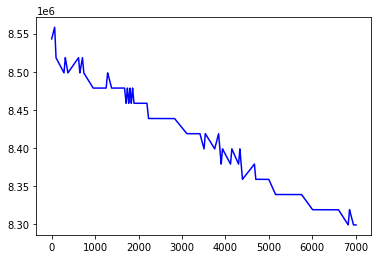

In [223]:
plt.plot(normal_df[55], 'b-')

In [227]:
persistence.plot(diagrams[55])

In [244]:
print('Entropy for timeseries #55:', Entropy_H0[55], Entropy_H1[55])

Entropy for timeseries #55 10.579131961997266 4.615550922643924


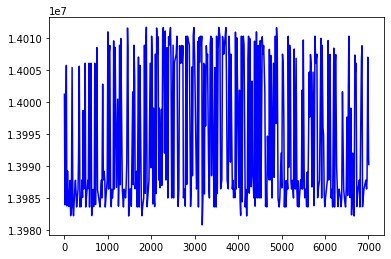

In [235]:
plt.plot(normal_df[25], 'b-')

In [236]:
persistence.plot(diagrams[25])

In [246]:
print('Entropy for timeseries #25:', Entropy_H0[25], Entropy_H1[25])

Entropy for timeseries #25: 11.027348108746713 9.796382374260716


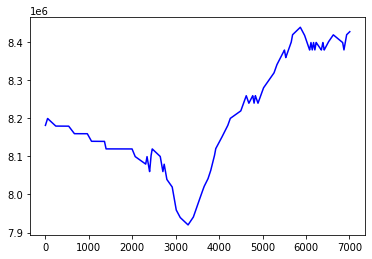

In [252]:
plt.plot(normal_df[491], 'b-')

In [255]:
plot_point_cloud(point_clouds_pca[491])

In [253]:
persistence.plot(diagrams[491])

In [254]:
print('Entropy for timeseries #25:', Entropy_H0[491], Entropy_H1[491])

Entropy for timeseries #25: 10.667595549181998 0.5357958588152831


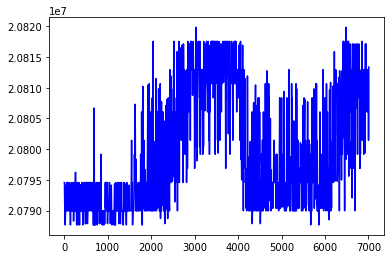

In [262]:
plt.plot(normal_df[189], 'b-')

In [263]:
print('Entropy for timeseries #25:', Entropy_H0[189], Entropy_H1[189])

Entropy for timeseries #25: 10.736229180426315 10.408366128202946


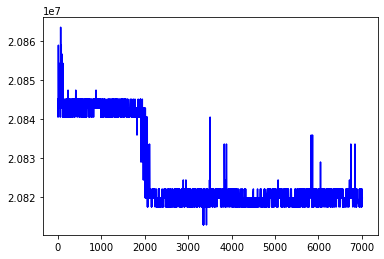

In [293]:
plt.plot(normal_df[188], 'b-')

In [294]:
print('Entropy for timeseries #25:', Entropy_H0[188], Entropy_H1[188])

Entropy for timeseries #25: 10.71644112399484 10.489766532456173


In [561]:
steps = [#("resampler", resampler),
         ("embedder", embedder),
         ("pca", batch_pca),
         #("persistence", persistence),
         #("scaling", scaling),
         #("entropy", entropy)
        ]
topological_transfomer = Pipeline(steps)

In [526]:
features_new = topological_transfomer.fit_transform(features.T)
features_new.shape

(2, 950, 3)

In [539]:
plot_point_cloud(features_new[0])

Just checking by comparing with a single embedding 

In [622]:
slug_data_single_df = pd.read_csv("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/0/test/WELL-00001_20170320130025.csv")
signal = slug_data_single_df["P-TPT"]

In [623]:
optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=optimal_embedding_dimension, time_delay=optimal_time_delay, dimension=6, stride=stride
)

signal_embedded = embedder.fit_transform(signal)

pca = PCA(n_components=3)
signal_embedded_pca = pca.fit_transform(signal_embedded)

plot_point_cloud(signal_embedded_pca)

Optimal embedding time delay based on mutual information: 289
Optimal embedding dimension based on false nearest neighbors: 9


In [541]:
signal_embedded_pca.shape

(1748, 3)

In [124]:
normal_data_df = pd.read_csv("../RareEventsDataset/3w_dataset-master/data/data/0/WELL-00004_20140807000129.csv")

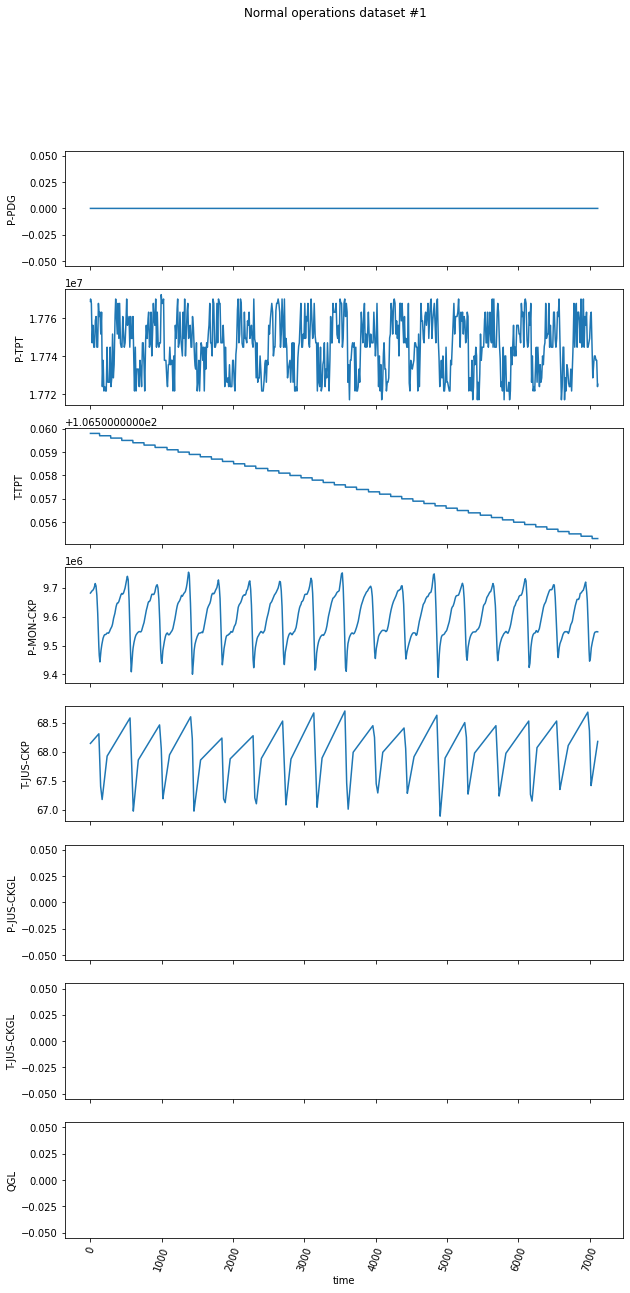

In [125]:
fig, ts = plt.subplots(8,figsize=(10,20),sharex = True)

fig.suptitle('Normal operations dataset #1')
ts[7].set_xlabel('time')
ts[0].set_ylabel("P-PDG")
ts[1].set_ylabel('P-TPT')
ts[2].set_ylabel('T-TPT')
ts[3].set_ylabel("P-MON-CKP")
ts[4].set_ylabel('T-JUS-CKP')
ts[5].set_ylabel('P-JUS-CKGL')
ts[6].set_ylabel("T-JUS-CKGL")
ts[7].set_ylabel('QGL')

degrees = 70
plt.xticks(rotation=degrees)

ts[0].plot(normal_data_df.index, normal_data_df["P-PDG"])
ts[1].plot(normal_data_df.index, normal_data_df["P-TPT"])
ts[2].plot(normal_data_df.index, normal_data_df["T-TPT"])
ts[3].plot(normal_data_df.index, normal_data_df["P-MON-CKP"])
ts[4].plot(normal_data_df.index, normal_data_df["T-JUS-CKP"])
ts[5].plot(normal_data_df.index, normal_data_df["P-JUS-CKGL"])
ts[6].plot(normal_data_df.index, normal_data_df["T-JUS-CKGL"])
ts[7].plot(normal_data_df.index, normal_data_df["QGL"])

In [53]:
slug_data_df = pd.read_csv("../RareEventsDataset/3w_dataset-master/data/data/3/WELL-00001_20170320130025.csv")

In [54]:
slug_data_df

timestamp  P-PDG       P-TPT     T-TPT  P-MON-CKP  \
0      2017-03-20 13:00:25.000000    0.0  14071870.0  117.1827  6085929.0   
1      2017-03-20 13:00:26.000000    0.0  14072180.0  117.1828  6087002.0   
2      2017-03-20 13:00:27.000000    0.0  14072490.0  117.1829  6088075.0   
3      2017-03-20 13:00:28.000000    0.0  14072800.0  117.1830  6089148.0   
4      2017-03-20 13:00:29.000000    0.0  14073110.0  117.1831  6090221.0   
...                           ...    ...         ...       ...        ...   
17971  2017-03-20 17:59:56.000000    0.0  14055950.0  116.8203  6025813.0   
17972  2017-03-20 17:59:57.000000    0.0  14055620.0  116.8200  6025539.0   
17973  2017-03-20 17:59:58.000000    0.0  14055290.0  116.8197  6025265.0   
17974  2017-03-20 17:59:59.000000    0.0  14054970.0  116.8194  6024990.0   
17975  2017-03-20 18:00:00.000000    0.0  14054640.0  116.8192  6024716.0   

       T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  QGL  class  
0       69.02943   3245327.0         NaN  0.0      3  
1       69.03323   3245327.0         NaN  0.0      3  
2       69.03702   3245327.0         NaN  0.0      3  
3       69.04082   3245327.0         NaN  0.0      3  
4       69.04462   3245327.0         NaN  0.0      3  
...          ...         ...         ...  ...    ...  
17971   70.36837   3246232.0         NaN  0.0      3  
17972   70.36488   3246232.0         NaN  0.0      3  
17973   70.36140   3246232.0         NaN  0.0      3  
17974   70.35791   3246232.0         NaN  0.0      3  
17975   70.35443   3246232.0         NaN  0.0      3  

[17976 rows x 10 columns]

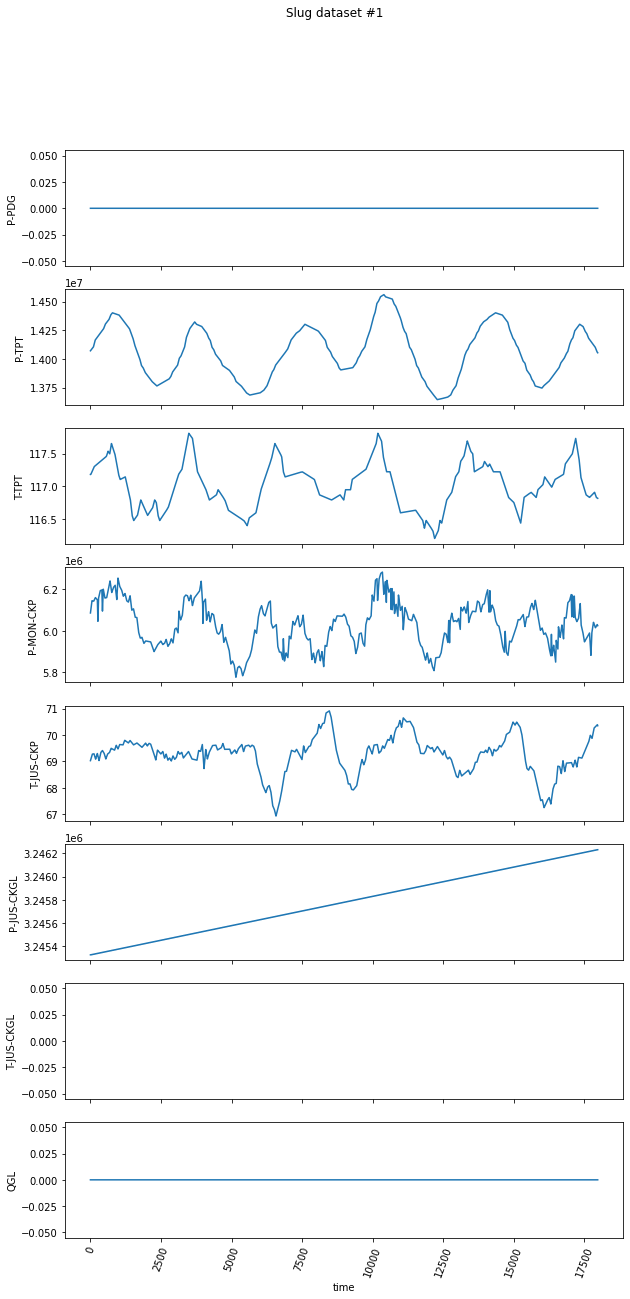

In [55]:
fig, ts = plt.subplots(8,figsize=(10,20),sharex = True)

fig.suptitle('Slug dataset #1')
ts[7].set_xlabel('time')
ts[0].set_ylabel("P-PDG")
ts[1].set_ylabel('P-TPT')
ts[2].set_ylabel('T-TPT')
ts[3].set_ylabel("P-MON-CKP")
ts[4].set_ylabel('T-JUS-CKP')
ts[5].set_ylabel('P-JUS-CKGL')
ts[6].set_ylabel("T-JUS-CKGL")
ts[7].set_ylabel('QGL')

degrees = 70
plt.xticks(rotation=degrees)

ts[0].plot(slug_data_df.index, slug_data_df["P-PDG"])
ts[1].plot(slug_data_df.index, slug_data_df["P-TPT"])
ts[2].plot(slug_data_df.index, slug_data_df["T-TPT"])
ts[3].plot(slug_data_df.index, slug_data_df["P-MON-CKP"])
ts[4].plot(slug_data_df.index, slug_data_df["T-JUS-CKP"])
ts[5].plot(slug_data_df.index, slug_data_df["P-JUS-CKGL"])
ts[6].plot(slug_data_df.index, slug_data_df["T-JUS-CKGL"])
ts[7].plot(slug_data_df.index, slug_data_df["QGL"])


In [385]:
period = 20
periodicSampler = Resampler(period=period)
signal = slug_data_df["P-TPT"]

#slug_data_df.index, slug_data_df["P-TPT"]
index_sampled, signal_sampled = periodicSampler.fit_transform_resample(slug_data_df.index, signal)

#print(index_sampled, signal_sampled, len(signal_sampled))

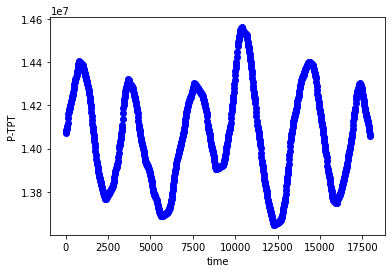

In [57]:
signal_downsampled = pd.DataFrame(signal_sampled,
                  index=index_sampled, columns=['P-TPT'])
#signal_downsampled['P-TPT']
plt.xlabel('time');
plt.ylabel('P-TPT');
plt.plot(signal_downsampled.index,signal_downsampled['P-TPT'], 'bo-')

In [126]:

print('length of signal to analyze', len(signal_downsampled))

max_time_delay = 300 
max_embedding_dimension = 30
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal_downsampled, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay

embedder = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

signal_embedded = embedder.fit_transform(signal_downsampled)

pca = PCA(n_components=3)
signal_embedded_pca = pca.fit_transform(signal_embedded)

plot_point_cloud(signal_embedded_pca)

length of signal to analyze 899
Optimal embedding time delay based on mutual information: 27
Optimal embedding dimension based on false nearest neighbors: 17


In [59]:

homology_dimensions = (0, 1, 2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

signal_embedded_reshaped = signal_embedded.reshape(1, *signal_embedded.shape)
print(f"y_wn_embedded_reshaped.shape",signal_embedded_reshaped.shape)
print(f"y_wn_embedded.shape", signal_embedded.shape)

PerHom_signal = VRP.fit_transform(signal_embedded_reshaped)
VRP.plot(PerHom_signal)

y_wn_embedded_reshaped.shape (1, 467, 17)
y_wn_embedded.shape (467, 17)


In [60]:
PE_slug = PersistenceEntropy()
PE_slug_norm = PersistenceEntropy(normalize=True)
features = PE_slug.fit_transform(PerHom_signal)
features_norm = PE_slug_norm.fit_transform(PerHom_signal)

In [61]:
features

array([[8.85156327, 2.40306284, 4.83440879]])

In [62]:
features_norm

array([[0.36769906, 0.11765671, 0.27278366]])

In [63]:
slug_data_sim_df = pd.read_csv("../RareEventsDataset/3w_dataset-master/data/data/3/SIMULATED_00013.csv")

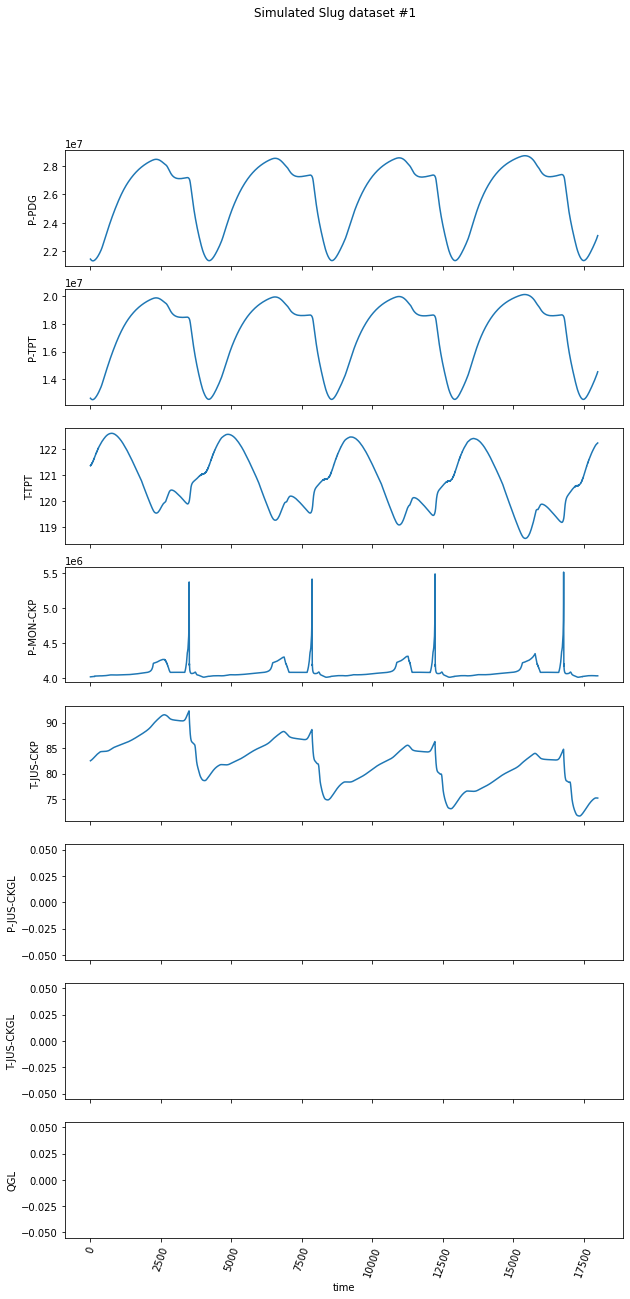

In [64]:
slug_data_sim_df = slug_data_sim_df.head(18000)

fig, ts = plt.subplots(8,figsize=(10,20),sharex = True)

fig.suptitle('Simulated Slug dataset #1')
ts[7].set_xlabel('time')
ts[0].set_ylabel("P-PDG")
ts[1].set_ylabel('P-TPT')
ts[2].set_ylabel('T-TPT')
ts[3].set_ylabel("P-MON-CKP")
ts[4].set_ylabel('T-JUS-CKP')
ts[5].set_ylabel('P-JUS-CKGL')
ts[6].set_ylabel("T-JUS-CKGL")
ts[7].set_ylabel('QGL')

degrees = 70
plt.xticks(rotation=degrees)

ts[0].plot(slug_data_sim_df.index, slug_data_sim_df["P-PDG"])
ts[1].plot(slug_data_sim_df.index, slug_data_sim_df["P-TPT"])
ts[2].plot(slug_data_sim_df.index, slug_data_sim_df["T-TPT"])
ts[3].plot(slug_data_sim_df.index, slug_data_sim_df["P-MON-CKP"])
ts[4].plot(slug_data_sim_df.index, slug_data_sim_df["T-JUS-CKP"])
ts[5].plot(slug_data_sim_df.index, slug_data_sim_df["P-JUS-CKGL"])
ts[6].plot(slug_data_sim_df.index, slug_data_sim_df["T-JUS-CKGL"])
ts[7].plot(slug_data_sim_df.index, slug_data_sim_df["QGL"])


In [65]:
period = 20
periodicSampler = Resampler(period=period)
signal = slug_data_sim_df["P-TPT"]

slug_data_sim_df.index, slug_data_sim_df["P-TPT"]
index_sampled, signal_sim_sampled = periodicSampler.fit_transform_resample(slug_data_sim_df.index, signal)


In [66]:
signal_sim_sampled

array([12632460., 12584720., 12551450., 12532900., 12528950., 12538280.,
       12559700., 12591610., 12632220., 12680630., 12735770., 12797520.,
       12864970., 12937750., 13015390., 13097370., 13183300., 13272980.,
       13366530., 13466430., 13578660., 13699310., 13829580., 13958740.,
       14091240., 14222930., 14353900., 14484490., 14613790., 14742200.,
       14869370., 14994930., 15120020., 15242630., 15363650., 15483060.,
       15600650., 15716220., 15829140., 15941130., 16050940., 16159480.,
       16266670., 16372180., 16476430., 16578660., 16679810., 16778580.,
       16875750., 16971250., 17064120., 17155800., 17244960., 17332190.,
       17417440., 17500310., 17581550., 17660170., 17737270., 17811970.,
       17884450., 17955680., 18024110., 18091280., 18156570., 18219680.,
       18281810., 18341380., 18399340., 18456400., 18511100., 18564650.,
       18617200., 18667610., 18717240., 18765580., 18812130., 18858220.,
       18902710., 18945770., 18988420., 19029230., 

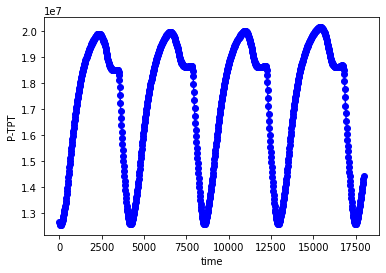

In [68]:
signal_sim_downsampled = pd.DataFrame(signal_sim_sampled,
                  index=index_sampled, columns=['P-TPT'])
plt.xlabel('time');
plt.ylabel('P-TPT');
plt.plot(signal_sim_downsampled.index,signal_sim_downsampled['P-TPT'], 'bo-')

In [73]:
print('length of signal to analyze', len(signal_sim_downsampled))

max_time_delay = 50 
max_embedding_dimension = 10
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal_sim_downsampled, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

signal_sim_embedded = embedder.fit_transform(signal_sim_downsampled)

pca = PCA(n_components=3)
signal_sim_embedded_pca = pca.fit_transform(signal_sim_embedded)

plot_point_cloud(signal_sim_embedded_pca)

length of signal to analyze 900
Optimal embedding time delay based on mutual information: 31
Optimal embedding dimension based on false nearest neighbors: 10


In [76]:
signal_sim_embedded_reshaped = signal_sim_embedded.reshape(1, *signal_sim_embedded.shape)
print(f"y_wn_embedded_reshaped.shape",signal_sim_embedded_reshaped.shape)
print(f"y_wn_embedded.shape", signal_sim_embedded_reshaped.shape)

PerHom_sim_signal = VRP.fit_transform(signal_sim_embedded_reshaped)
features_sim = PE_slug.fit_transform(PerHom_signal)
features_sim_norm = PE_slug_norm.fit_transform(PerHom_signal)

y_wn_embedded_reshaped.shape (1, 621, 10)
y_wn_embedded.shape (1, 621, 10)


In [77]:
features_sim

array([[8.85156327, 2.40306284, 4.83440879]])

In [78]:
features_sim_norm

array([[0.36769906, 0.11765671, 0.27278366]])

In [79]:
VRP.plot(PerHom_sim_signal)

In [82]:
PerHom_sim_signal.shape

(1, 919, 3)

In [89]:
PerHom_signal.shape

#tmp = np.vstack([PerHom_signal,PerHom_sim_signal])
#tmp.shape

(1, 533, 3)

In [94]:
diagramScaler = Scaler()
PerHom_signal_scaled = diagramScaler.fit_transform(PerHom_signal)
diagramScaler.plot(PerHom_signal_scaled)

In [92]:
PerHom_signal_sim_scaled = diagramScaler.fit_transform(PerHom_sim_signal)
diagramScaler.plot(PerHom_signal_sim_scaled)

In [95]:
features_sim = PE_slug.fit_transform(PerHom_signal_scaled)
features_sim_norm = PE_slug_norm.fit_transform(PerHom_signal_scaled)
features_sim

array([[8.85156327, 2.40306284, 4.83440879]])

In [96]:
features_sim_norm

array([[  1.49319727,   1.05423515, -11.44457834]])

In [111]:
HK = HeatKernel(sigma=.15, n_bins=60, n_jobs=-1) 
HK_slug = HK.fit_transform_plot(PerHom_signal_scaled, homology_dimension_idx=1)

In [112]:
HK.fit_transform_plot(PerHom_signal_sim_scaled, homology_dimension_idx=1)

array([[[[ 5.07638691e+02,  4.99572666e+02,  4.91460183e+02, ...,
           1.66820580e+01,  8.32249323e+00,  0.00000000e+00],
         [ 5.00163881e+02,  4.92070493e+02,  4.83931025e+02, ...,
           8.36008392e+00,  0.00000000e+00, -8.32249323e+00],
         [ 4.92624107e+02,  4.84503736e+02,  4.76337670e+02, ...,
           0.00000000e+00, -8.36008392e+00, -1.66820580e+01],
         ...,
         [ 1.78456729e+01,  8.93264763e+00,  0.00000000e+00, ...,
          -4.76337670e+02, -4.83931025e+02, -4.91460183e+02],
         [ 8.91354577e+00,  0.00000000e+00, -8.93264763e+00, ...,
          -4.84503736e+02, -4.92070493e+02, -4.99572666e+02],
         [ 0.00000000e+00, -8.91354577e+00, -1.78456729e+01, ...,
          -4.92624107e+02, -5.00163881e+02, -5.07638691e+02]],

        [[ 6.89021565e+00,  6.71087491e+00,  6.20037748e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 7.07434908e+00,  6.89021565e+00,  6.36607574e+00, ...,
           0.00000000e